In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_partial.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/test_classes_partial.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/test.zip
!unzip -q /content/test_partial.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm test.zip
!rm test_partial.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from tensorflow.keras import datasets, layers, models

In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (224, 224)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

import cv2
import numpy as np

# Custom preprocessing function for train data
def preprocess_image(img):
    # Randomly select transformations to apply
    do_blur = np.random.rand() < 0.1  # 10% chance of applying blur
    do_grayscale = np.random.rand() < 0.5  # 50% chance of applying grayscale

    # Apply transformations based on conditions
    if do_blur:
        img = cv2.GaussianBlur(img, (5, 5), 0)

    #if do_grayscale:
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img


train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.3,
        rotation_range = 10, #Degrees to either side, test set doesn't seem too varied
        height_shift_range = 0.05, # % change up or down
        width_shift_range = .1, # # change left or right
        zoom_range = .2, # also little variation
        brightness_range = (0,1), #biggest impact, keep high
        fill_mode = "reflect", #when we move the image, what replaces the old location spot
        preprocessing_function=preprocess_image,
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.3
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=64,
        class_mode='categorical',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=64,
        class_mode='categorical',
        subset="validation",
        seed=42)

from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
           'balanced',
            classes = np.unique(train_generator.classes),
            y=train_generator.classes)

picture_weights = {i: class_weights[i] for i in range(len(class_weights))}
picture_weights[14] = 1 # manually increase stop signs


Found 27447 images belonging to 43 classes.
Found 11762 images belonging to 43 classes.


In [ ]:
picture_weights

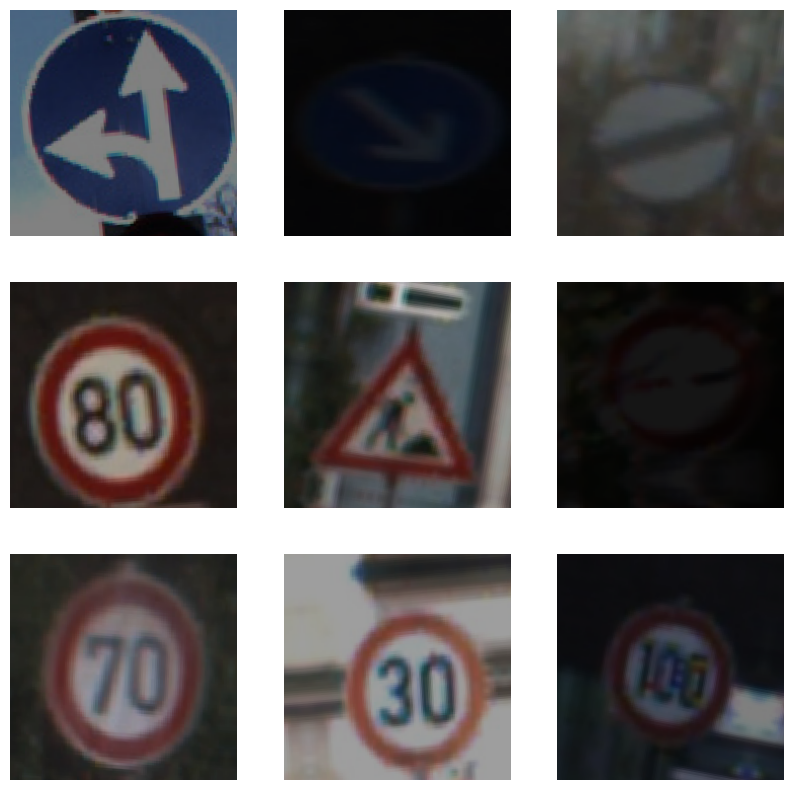

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in train_generator:
    for i in range(9):
        first_image = images.tolist()[i]
        ax = plt.subplot(3, 3, i + 1)
        f = np.array(first_image)*255
        plt.imshow(f.astype("uint8"))
        # plt.title(int(labels[i]))
        plt.axis("off")
    break

In [ ]:
# Load the pre-trained VGG16 model (excluding the top layer)
#vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

densenet = tf.keras.applications.DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

# Create your CNN model based on DenseNet
model = Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dense(43, activation='softmax'))  # 43 is the number of classes in this example

# #Adversarial Learning
# import neural_structured_learning as nsl
# adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
# adv_model = nsl.keras.AdversarialRegularization(model, adv_config)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 43)                2157611   
                                                                 
Total params: 9,195,115
Trainable params: 9,111,467
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
# Train the model using the generator
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
training_history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=35,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        class_weight=picture_weights, #Overemphasize smaller sampled signs
        callbacks=[early_stop],
        )

Epoch 1/35
428/428 [==============================] - 555s 1s/step - loss: 2.3715 - accuracy: 0.5206 - val_loss: 2.5351 - val_accuracy: 0.5406
Epoch 2/35
428/428 [==============================] - 549s 1s/step - loss: 0.7753 - accuracy: 0.7625 - val_loss: 0.8728 - val_accuracy: 0.7817
Epoch 3/35
428/428 [==============================] - 552s 1s/step - loss: 0.4318 - accuracy: 0.8663 - val_loss: 1.1920 - val_accuracy: 0.8180
Epoch 4/35
428/428 [==============================] - 544s 1s/step - loss: 0.2744 - accuracy: 0.9099 - val_loss: 0.9420 - val_accuracy: 0.8476
Epoch 5/35
428/428 [==============================] - 553s 1s/step - loss: 0.2242 - accuracy: 0.9293 - val_loss: 0.6663 - val_accuracy: 0.8990
Epoch 6/35
330/428 [======================>.......] - ETA: 1:59 - loss: 0.1922 - accuracy: 0.9418

## Testing the model
Once you have built and trained your model, the next step is to run the test images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.



```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



In [ ]:
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
#probabilities = model.predict(test_generator)


Found 12630 images belonging to 1 classes.


In [ ]:

probabilities = model.predict(test_generator)
predicted_labels = np.argmax(probabilities, axis=1)

true_labels = test_generator.classes

7/7 [==============================] - 7s 240ms/step


In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [ ]:
test_generator

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels,predicted_labels)

array([[ 0, 11,  8, ...,  9,  2,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [ ]:
from google.colab import files
pd.DataFrame(predicted_labels).to_csv('spencer_holdout_18e_98a.csv')
files.download("spencer_holdout_18e_98a.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Partial Hold out Dataset
You're given the answers to the first 200 images in the hold out dataset.

Once you have predictions for the partial holdout dataset, you'll need to compare those predictions against the "ground truth" class labels in `test_classes_partial.csv` to evaluate how well the model does.

Make sure to use the insights gained from the partial hold out dataset in your executive summary.

Once you feel confident, you will need to predict for the full test dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```

In [ ]:
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['test_partial'],
        target_size=image_size,
        class_mode='categorical',
        shuffle=False)
probabilities = model.predict(test_generator)

# Load the ground truth labels from the CSV file
test_labels = pd.read_csv('test_classes_partial.csv')

# Get the predicted labels from the model
predicted_labels = [np.argmax(probas) for probas in probabilities]

# Get the true labels from the ground truth
true_labels = test_labels['ClassId'].to_list()

Found 201 images belonging to 1 classes.
7/7 [==============================] - 7s 362ms/step


In [ ]:
# Compute the metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.31840796019900497
Precision: 0.3623068132725727
Recall: 0.31840796019900497
F1 Score: 0.2941923220296799
